In [1]:
%pylab inline
from utils import *
from ipdb import set_trace
import numpy as np
import torch
import os
from torch import nn
from torch import optim
from torch.nn import functional as F
from torch import autograd
# from torch.autograd import Variable
import nibabel as nib
from torch.utils.data.dataset import Dataset
from torch.utils.data import dataloader
from nilearn import plotting
from ADNI_dataset import *
from BRATS_dataset import *
from ATLAS_dataset import *
from Model_alphaWGAN import *

Populating the interactive namespace from numpy and matplotlib


# Configuration

In [2]:
BATCH_SIZE=4
gpu = True
workers = 4

LAMBDA= 10
_eps = 1e-15
Use_BRATS=False
Use_ATLAS = False

#setting latent variable sizes
latent_dim = 1000

gpu_0 = 1
gpu_1 = 1
torch_seed = 42
# r_g = torch.manual_seed(torch_seed)

In [3]:
dataset = ADNIdataset(augmentation=True, img_size=64)
# trainset, testset = data.random_split(dataset, [5, 5], generator=r_g)
train_loader = torch.utils.data.DataLoader(dataset,batch_size=BATCH_SIZE,
                                          shuffle=True,num_workers=workers)
# test_loader = torch.utils.data.DataLoader(testset,batch_size=BATCH_SIZE,
#                                           shuffle=True,num_workers=workers)
# if Use_BRATS:
#     #'flair' or 't2' or 't1ce'
#     trainset = BRATSdataset(imgtype='flair')
#     train_loader = torch.utils.data.DataLoader(trainset,batch_size = BATCH_SIZE, shuffle=True,
#                                                num_workers=workers)
# if Use_ATLAS:
#     trainset = ATLASdataset(augmentation=True)
#     train_loader = torch.utils.data.DataLoader(trainset,batch_size=BATCH_SIZE,
#                                           shuffle=True,num_workers=workers)

In [4]:
def inf_train_gen(data_loader):
    while True:
        for _,images in enumerate(data_loader):
            yield images

In [5]:
G = Generator(noise = latent_dim)
CD = Code_Discriminator(code_size = latent_dim ,num_units = 4096)
D = Discriminator(is_dis=True)
E = Discriminator(out_class = latent_dim,is_dis=False, img_size=128)

G.cuda(gpu_0)
D.cuda(gpu_0)
CD.cuda(gpu_1)
E.cuda(gpu_1)

Discriminator(
  (conv1): Conv3d(1, 64, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
  (conv2): Conv3d(64, 128, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
  (bn2): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv3d(128, 256, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
  (bn3): BatchNorm3d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv3d(256, 512, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
  (bn4): BatchNorm3d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv3d(512, 1000, kernel_size=(4, 4, 4), stride=(1, 1, 1))
  (bn5): BatchNorm3d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv6): Conv3d(1000, 1000, kernel_size=(3, 3, 3), stride=(1, 1, 1))
)

In [6]:
g_optimizer = optim.Adam(G.parameters(), lr=0.0002)
d_optimizer = optim.Adam(D.parameters(), lr=0.0002)
e_optimizer = optim.Adam(E.parameters(), lr = 0.0002)
cd_optimizer = optim.Adam(CD.parameters(), lr = 0.0002)

In [7]:
def calc_gradient_penalty(model, x, x_gen, w=10, cuda_ind=0):
    """WGAN-GP gradient penalty"""
    assert x.size()==x_gen.size(), "real and sampled sizes do not match"
    alpha_size = tuple((len(x), *(1,)*(x.dim()-1)))
    alpha_t = torch.cuda.FloatTensor if x.is_cuda else torch.Tensor
    alpha = alpha_t(*alpha_size).uniform_().cuda(cuda_ind)
    #x_hat = x.data*alpha + x_gen.data*(1-alpha)
    x_hat = x*alpha + x_gen*(1-alpha)
    # x_hat = Variable(x_hat, requires_grad=True)
    x_hat.requires_grad = True

    def eps_norm(x):
        x = x.view(len(x), -1)
        return (x*x+_eps).sum(-1).sqrt()
    def bi_penalty(x):
        return (x-1)**2
    grad_xhat = torch.autograd.grad(model(x_hat).sum(), x_hat, create_graph=True, only_inputs=True)[0]

    penalty = w*bi_penalty(eps_norm(grad_xhat)).mean()
    return penalty

# Training

In [8]:
torch.autograd.set_detect_anomaly(True)
#remove Variable usage
# real_y = torch.ones((BATCH_SIZE, 1)).cuda()#async=True))
# fake_y = torch.zeros((BATCH_SIZE, 1)).cuda()#async=True))

criterion_bce = nn.BCELoss()
criterion_l1 = nn.L1Loss()
criterion_mse = nn.MSELoss()

In [9]:
# load the highest savepoints of all models
iteration = load_checkpoint(G, D, E, CD, '_iter', path='mmd_checkpoint')
df = load_loss()

In [10]:
g_iter = 1
d_iter = 3
cd_iter =1
TOTAL_ITER = 200000
gen_load = inf_train_gen(train_loader)
test_load = inf

lossStr [0/200000]
        D: -15.1   
        En_Ge: 9.06    
        Code: 4.53    


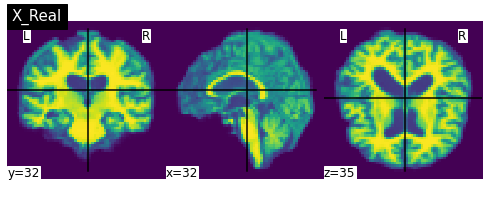

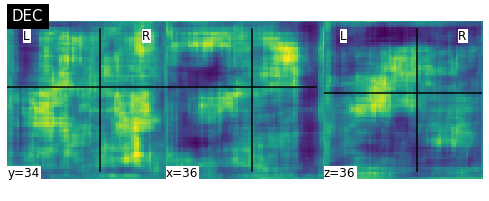

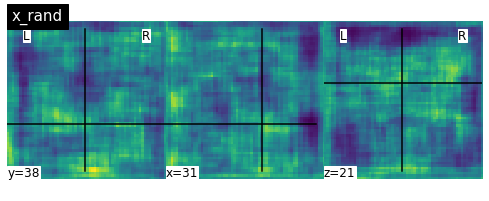

lossStr [100/200000]
        D: -1.56e+02
        En_Ge: -15.7   
        Code: 2.79    


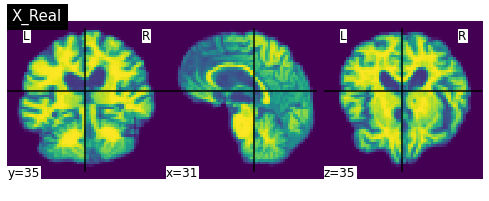

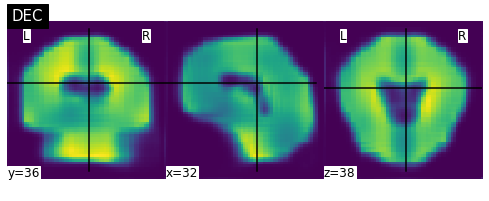

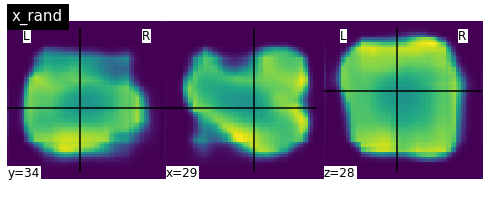

lossStr [200/200000]
        D: -1.07e+02
        En_Ge: -59.2   
        Code: 5.11    


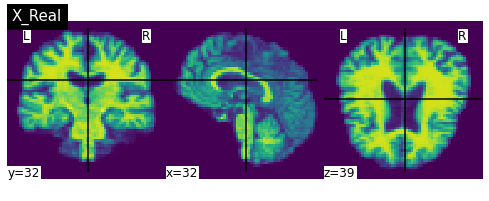

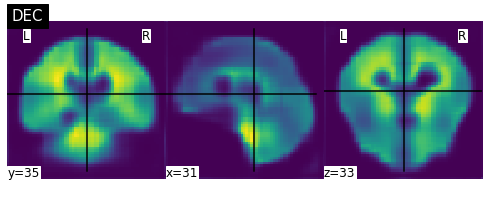

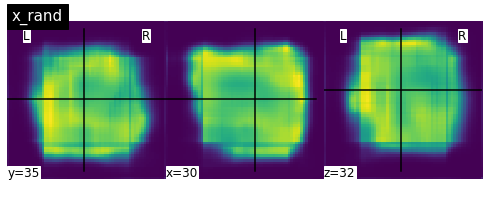

lossStr [300/200000]
        D: -1.09e+02
        En_Ge: -49.0   
        Code: 0.873   


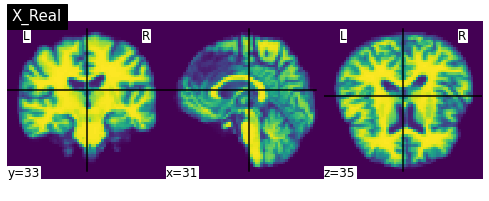

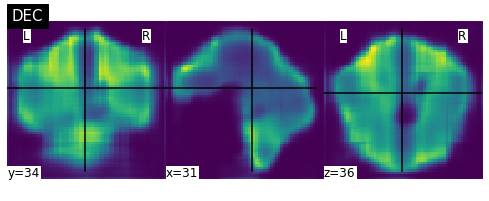

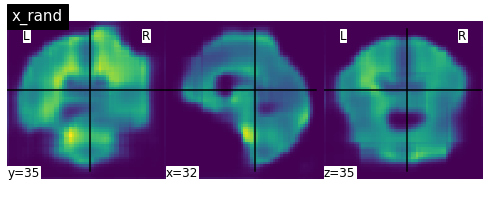

lossStr [400/200000]
        D: -1.4e+02
        En_Ge: -1.13e+02
        Code: 3.04    


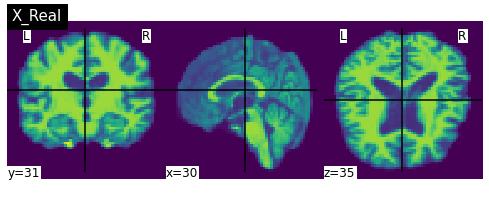

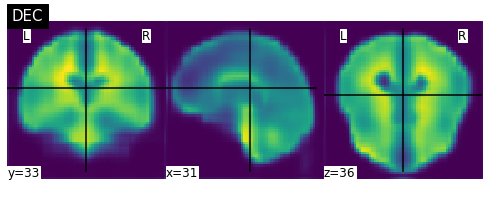

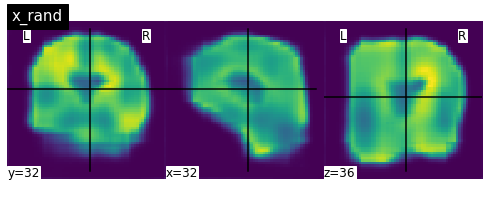

lossStr [500/200000]
        D: -64.5   
        En_Ge: -19.0   
        Code: 2.19    


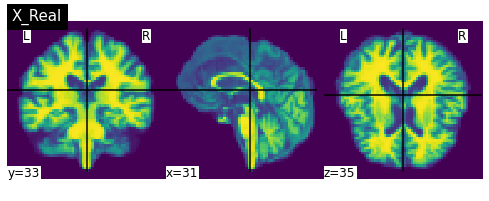

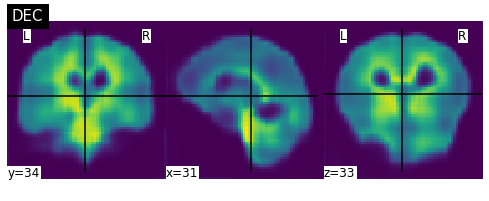

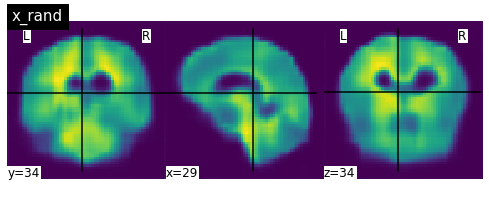


Count: 500 Mean: 1558.148941532258
index: 500, sample_mean: 0.005343457218259573 sample_var: 0.6844230890274048, yellow_mean: -0.002219937276095152 yellow_var: 0.9997832775115967


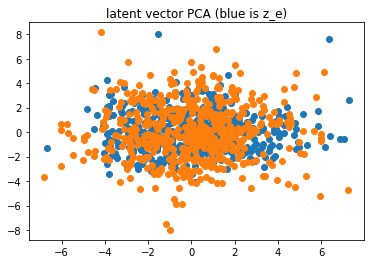

index: 500, sample_mean: -0.8569524884223938 sample_var: 0.049825239926576614, yellow_mean: -0.8583786487579346 yellow_var: 0.056657299399375916


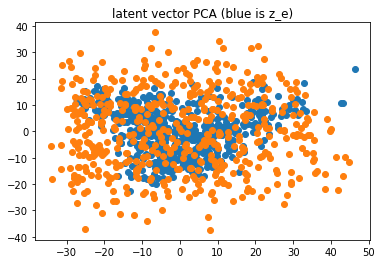

lossStr [600/200000]
        D: -1.04e+02
        En_Ge: -56.8   
        Code: 32.8    


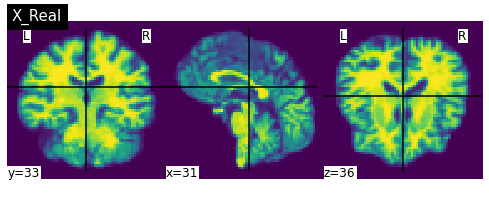

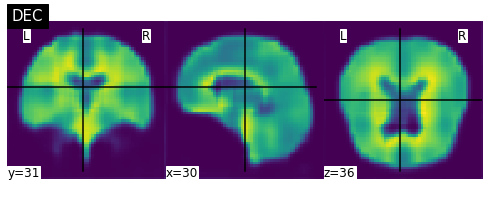

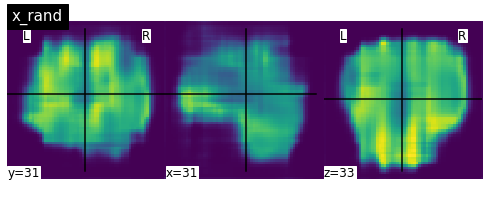

lossStr [700/200000]
        D: -64.7   
        En_Ge: -64.8   
        Code: 0.485   


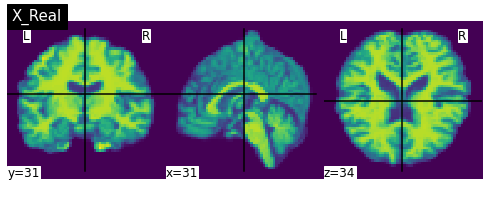

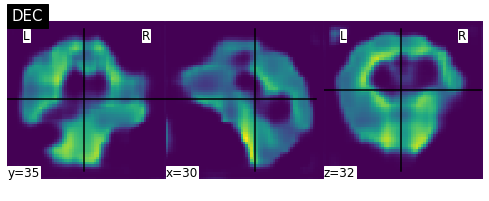

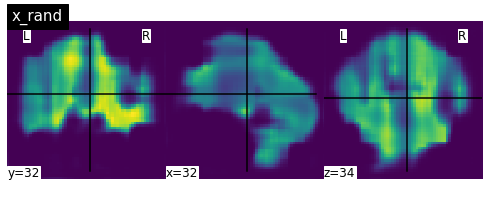

lossStr [800/200000]
        D: -1.65e+02
        En_Ge: -69.4   
        Code: 1.92    


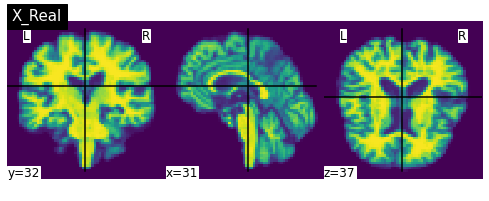

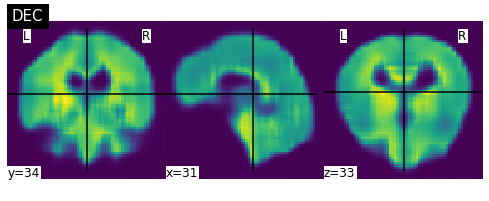

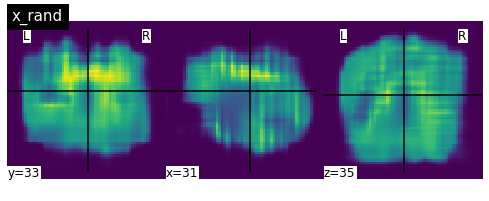

lossStr [900/200000]
        D: -66.6   
        En_Ge: -74.2   
        Code: 18.8    


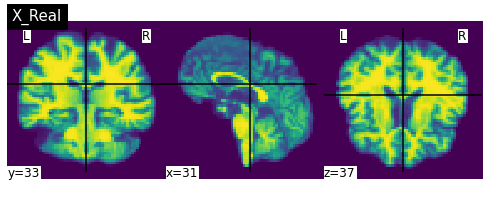

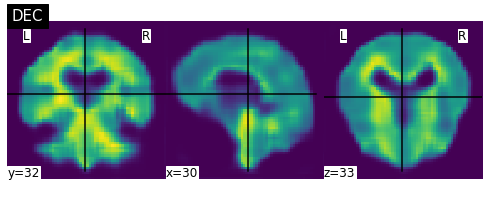

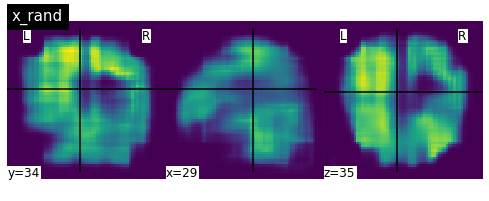

lossStr [1000/200000]
        D: -1.21e+02
        En_Ge: -68.5   
        Code: 2.68    


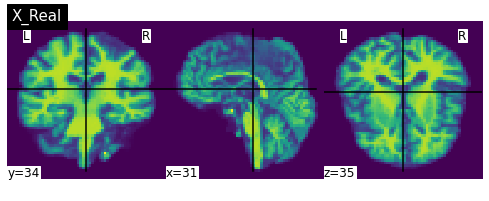

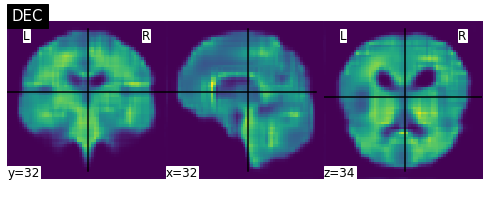

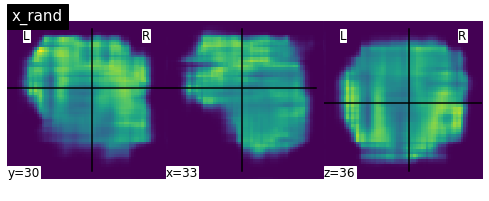


Count: 1000 Mean: 3749.3579889112902
index: 1000, sample_mean: -0.02507111430168152 sample_var: 0.30417871475219727, yellow_mean: -0.0003758198581635952 yellow_var: 1.0019302368164062


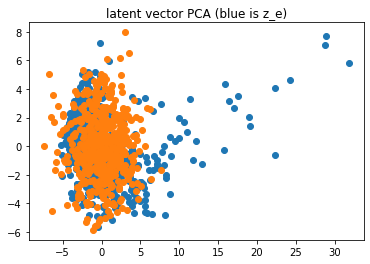

index: 1000, sample_mean: -0.8030143976211548 sample_var: 0.09173373878002167, yellow_mean: -0.8604015707969666 yellow_var: 0.05519186705350876


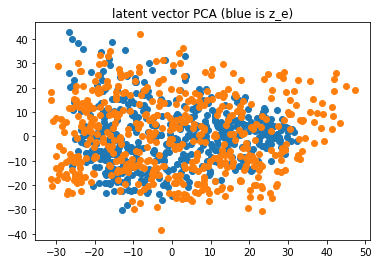

lossStr [1100/200000]
        D: -53.1   
        En_Ge: -1.12e+02
        Code: 3.02    


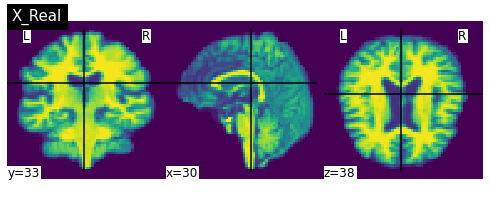

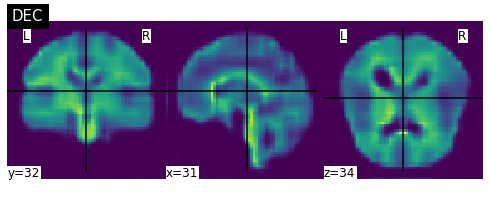

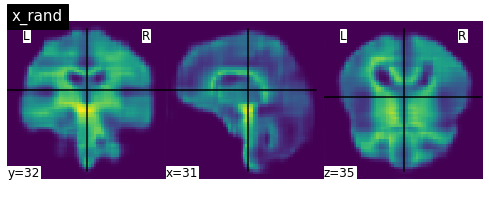

lossStr [1200/200000]
        D: -73.9   
        En_Ge: 8.92    
        Code: 14.2    


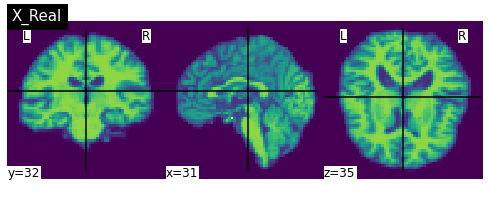

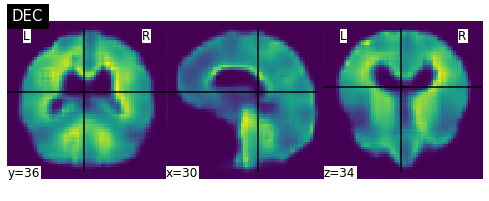

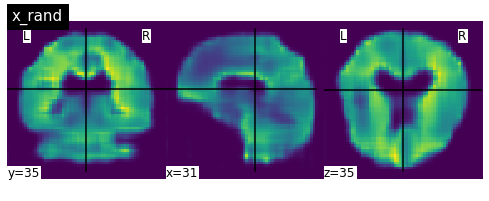

lossStr [1300/200000]
        D: -69.1   
        En_Ge: -20.9   
        Code: 17.8    


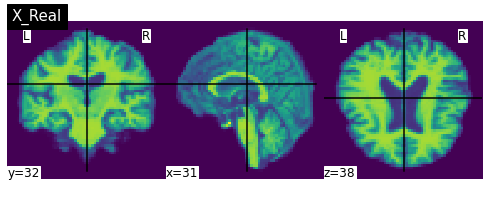

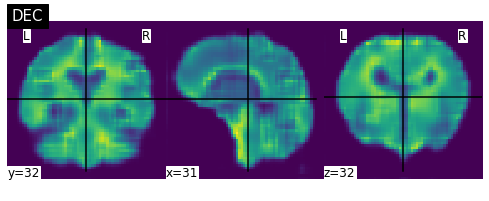

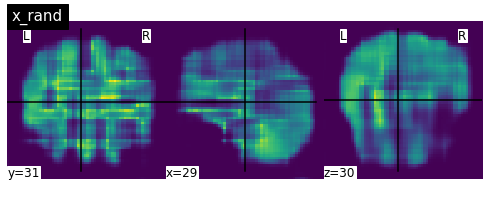

lossStr [1400/200000]
        D: -55.4   
        En_Ge: 76.9    
        Code: -0.585  


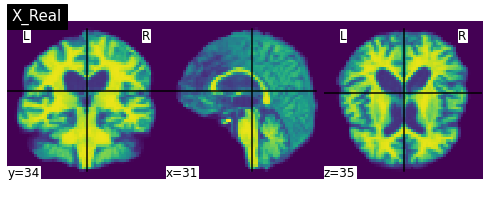

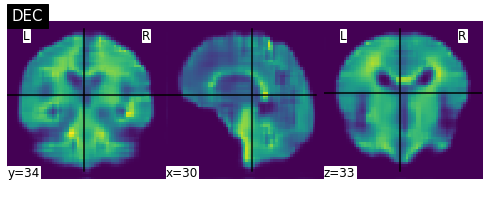

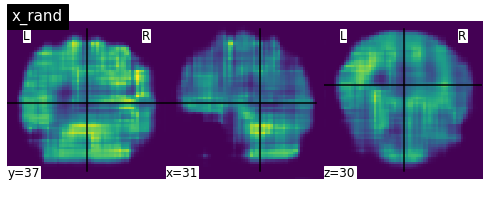

lossStr [1500/200000]
        D: -86.6   
        En_Ge: 87.3    
        Code: 0.898   


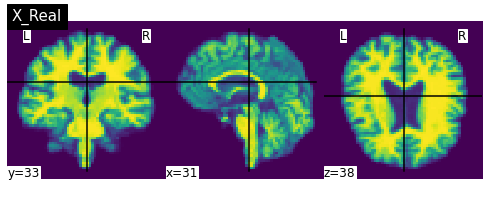

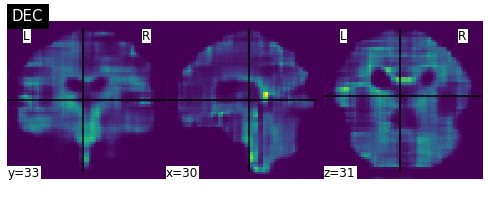

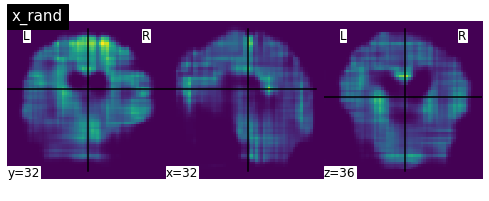


Count: 1500 Mean: 4274.970388104839
index: 1500, sample_mean: 0.017611918970942497 sample_var: 0.14205576479434967, yellow_mean: 0.004132839385420084 yellow_var: 0.9991093873977661


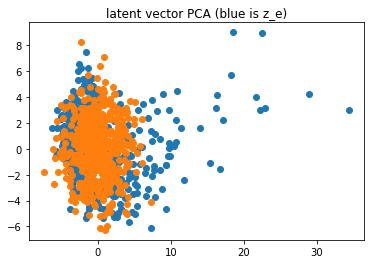

index: 1500, sample_mean: -0.9191364645957947 sample_var: 0.021398454904556274, yellow_mean: -0.8601361513137817 yellow_var: 0.05559436231851578


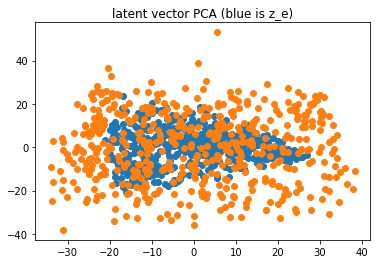

lossStr [1600/200000]
        D: -62.1   
        En_Ge: 60.4    
        Code: 0.433   


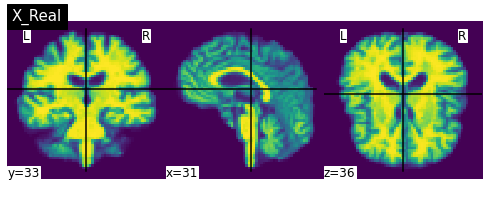

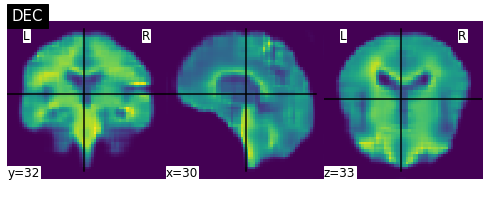

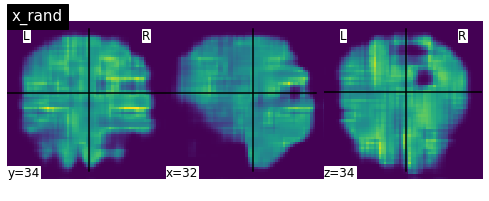

lossStr [1700/200000]
        D: -14.8   
        En_Ge: 14.5    
        Code: -2.42   


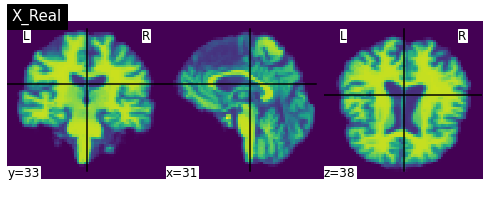

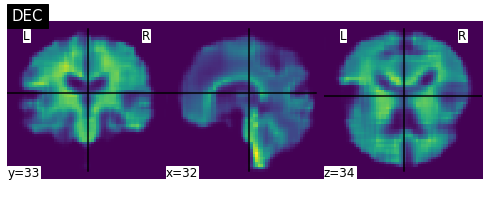

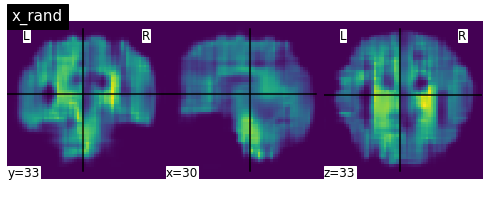

lossStr [1800/200000]
        D: -40.7   
        En_Ge: 50.9    
        Code: -2.47   


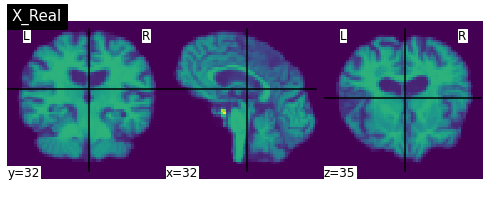

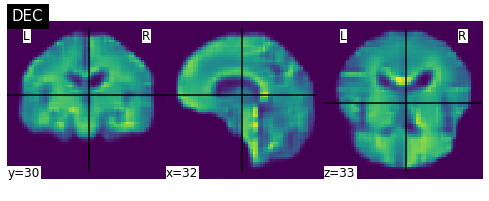

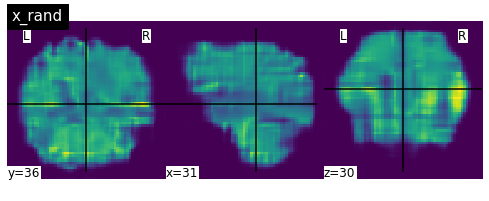

lossStr [1900/200000]
        D: -44.0   
        En_Ge: 41.4    
        Code: 15.8    


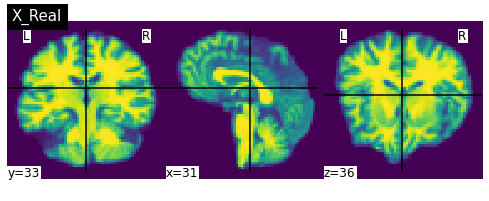

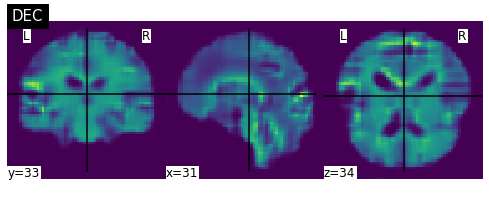

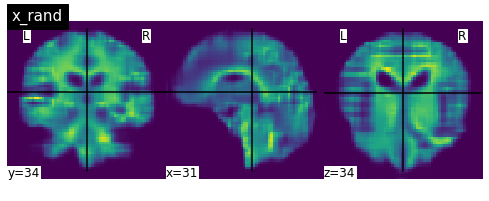

lossStr [2000/200000]
        D: -82.8   
        En_Ge: 1.59e+02
        Code: 3.04    


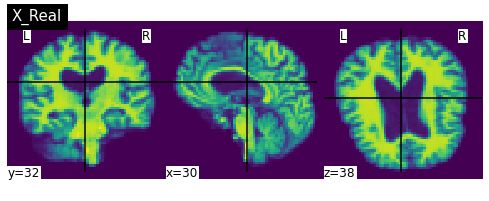

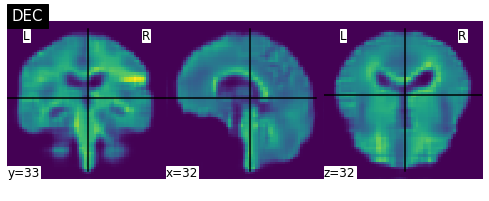

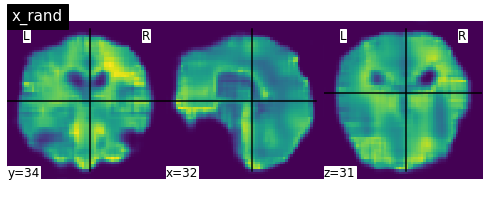


Count: 2000 Mean: 3157.751512096774
index: 2000, sample_mean: -0.012555968947708607 sample_var: 0.5587821006774902, yellow_mean: -8.235237328335643e-05 yellow_var: 1.0009329319000244


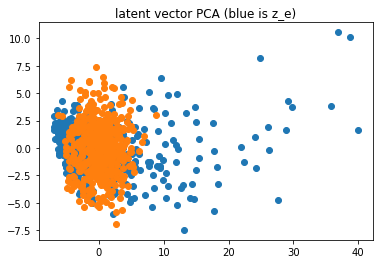

index: 2000, sample_mean: -0.8111242055892944 sample_var: 0.08235849440097809, yellow_mean: -0.8591458201408386 yellow_var: 0.05605270713567734


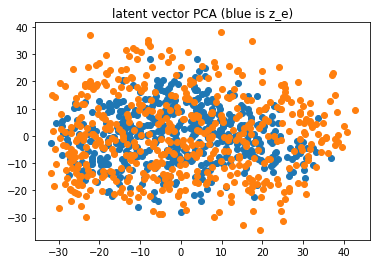

lossStr [2100/200000]
        D: -43.6   
        En_Ge: 93.1    
        Code: 28.8    


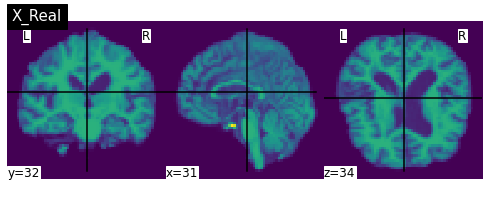

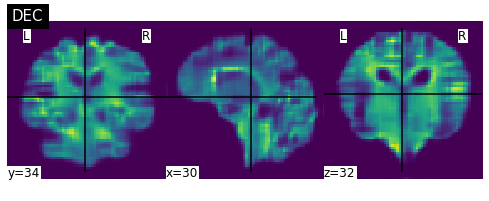

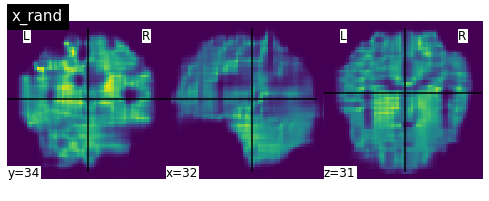

lossStr [2200/200000]
        D: -52.2   
        En_Ge: 70.2    
        Code: 72.5    


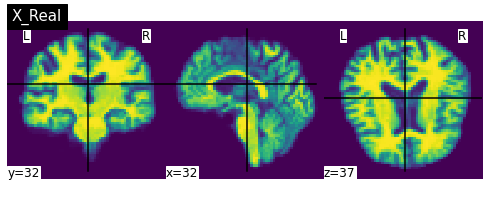

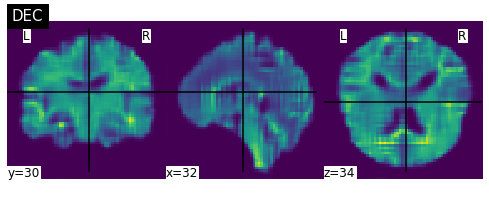

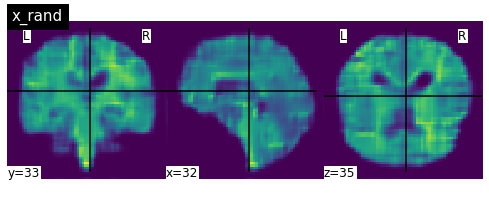

lossStr [2300/200000]
        D: -53.8   
        En_Ge: 60.6    
        Code: 12.6    


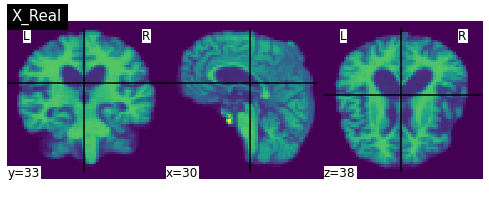

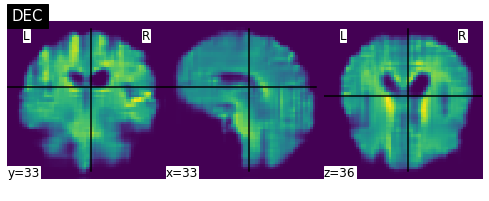

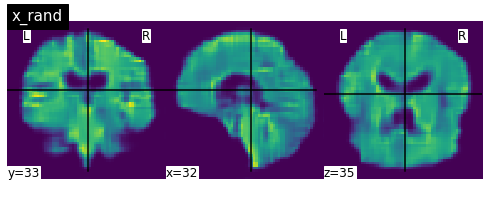

lossStr [2400/200000]
        D: -42.7   
        En_Ge: 67.7    
        Code: 4.85    


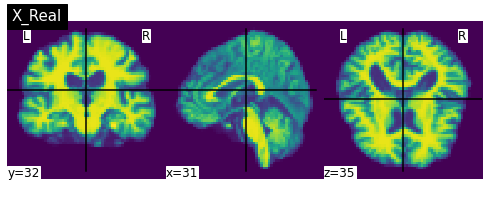

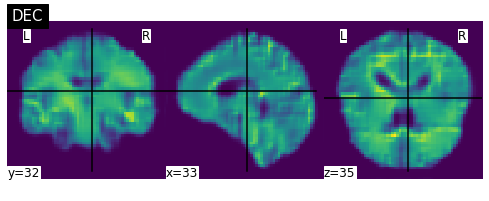

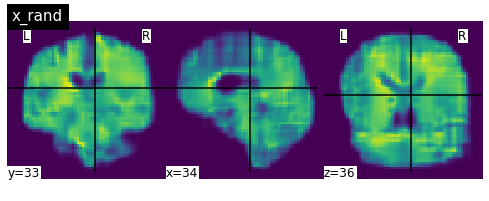

lossStr [2500/200000]
        D: -50.2   
        En_Ge: 63.6    
        Code: 25.4    


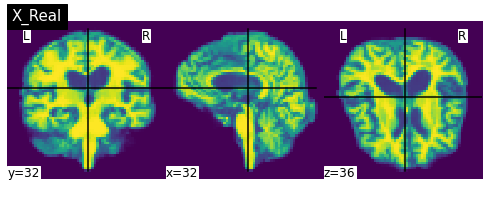

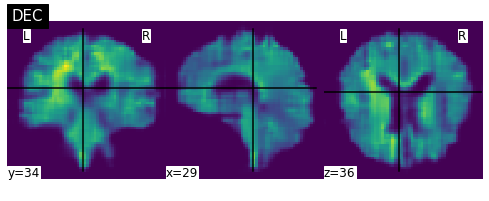

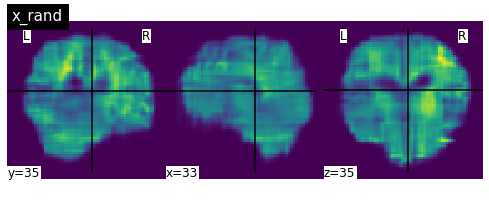


Count: 2500 Mean: 1974.473160282258
index: 2500, sample_mean: 0.0032177858520299196 sample_var: 0.14838860929012299, yellow_mean: 0.0009364786092191935 yellow_var: 1.001198649406433


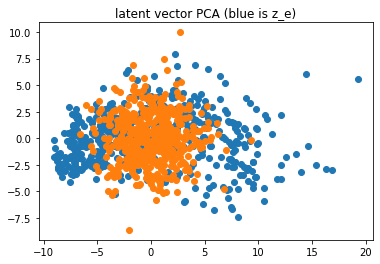

lossStr [2600/200000]
        D: -34.1   
        En_Ge: 48.4    
        Code: 93.6    


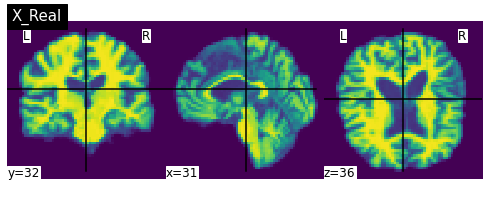

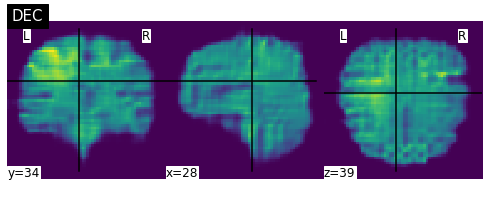

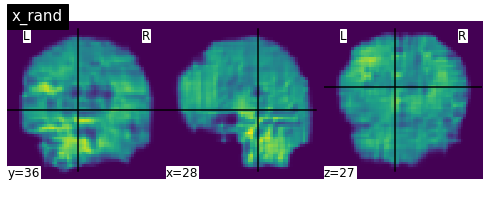

lossStr [2700/200000]
        D: -52.6   
        En_Ge: 89.0    
        Code: 20.1    


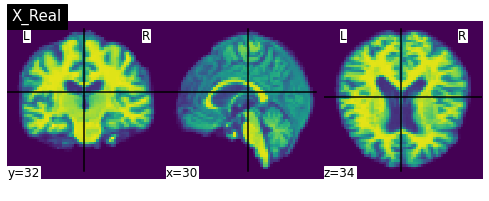

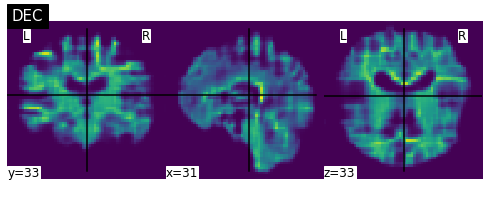

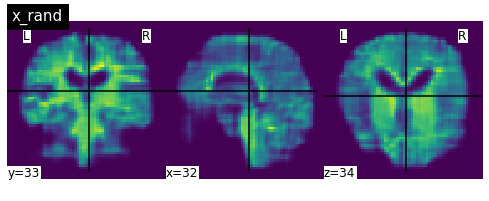

lossStr [2800/200000]
        D: -62.5   
        En_Ge: 45.4    
        Code: 12.6    


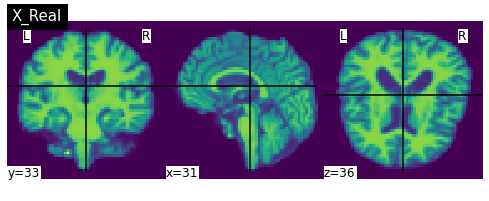

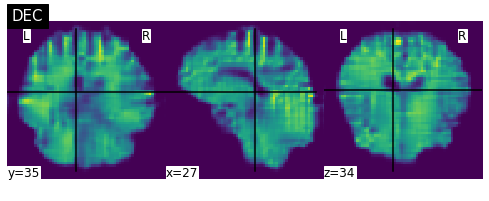

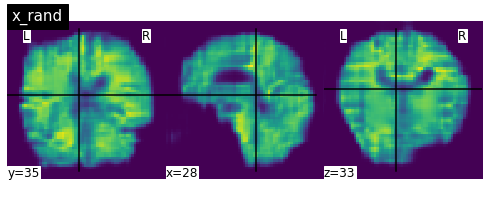

lossStr [2900/200000]
        D: -46.3   
        En_Ge: 1.15e+02
        Code: 73.6    


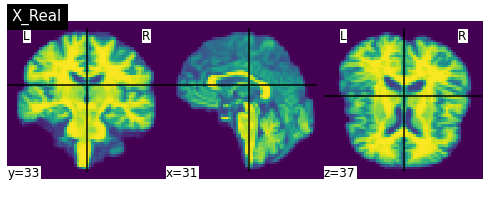

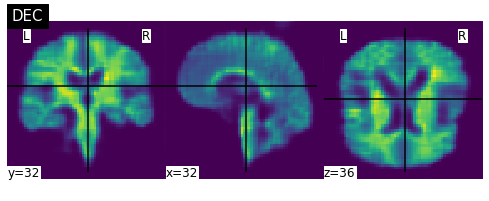

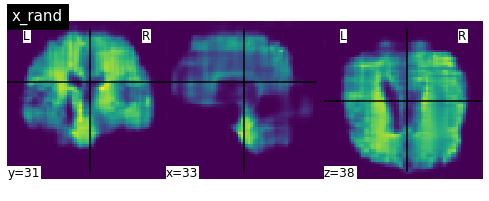

lossStr [3000/200000]
        D: -56.0   
        En_Ge: 1.65e+02
        Code: 16.1    


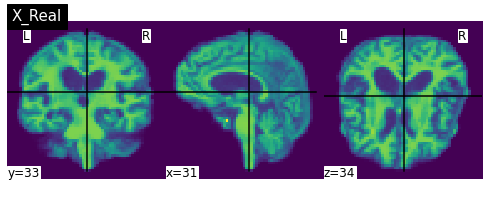

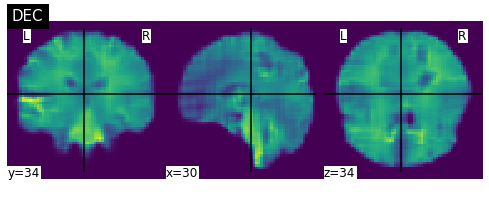

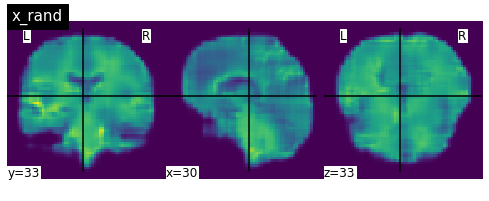


Count: 3000 Mean: 2924.3329133064517
index: 3000, sample_mean: -0.001457663020119071 sample_var: 0.29980409145355225, yellow_mean: 0.0015410968335345387 yellow_var: 1.0022625923156738


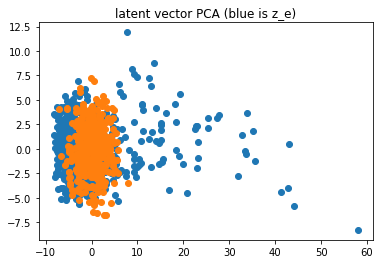

index: 3000, sample_mean: -0.8120428323745728 sample_var: 0.08121191710233688, yellow_mean: -0.859171986579895 yellow_var: 0.05600620433688164


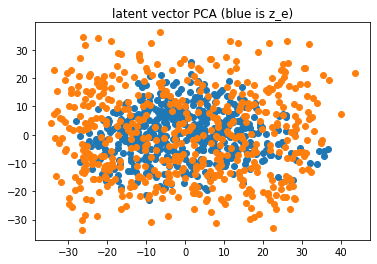

lossStr [3100/200000]
        D: -44.9   
        En_Ge: 67.7    
        Code: -9.65   


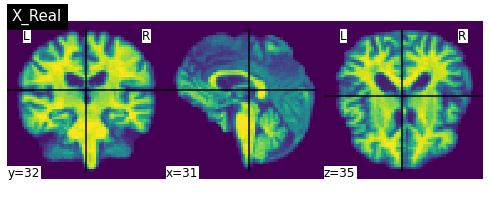

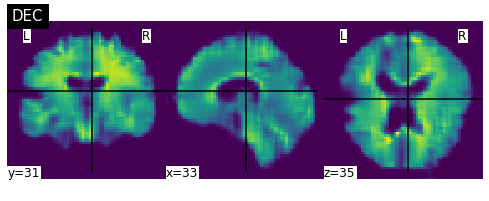

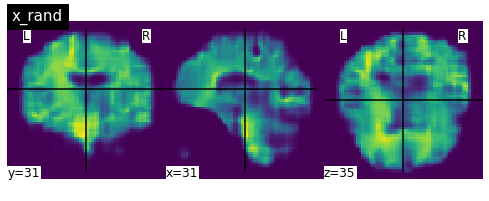

lossStr [3200/200000]
        D: -30.9   
        En_Ge: 1.19e+02
        Code: 27.7    


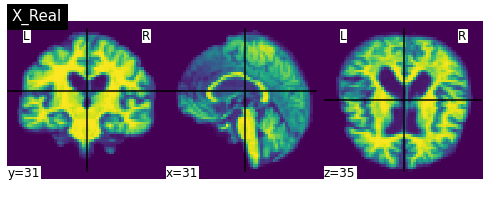

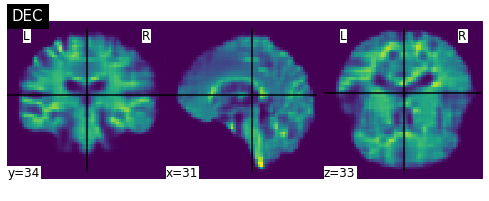

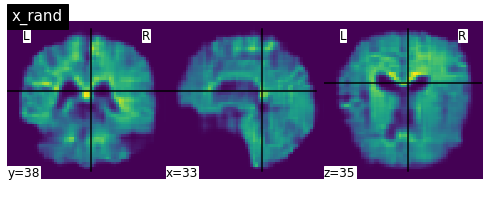

lossStr [3300/200000]
        D: -34.2   
        En_Ge: 1.35e+02
        Code: 4.79    


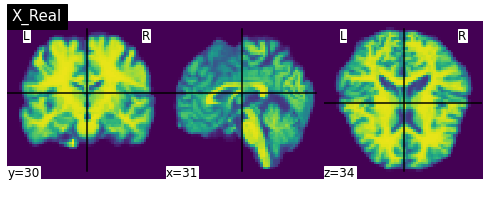

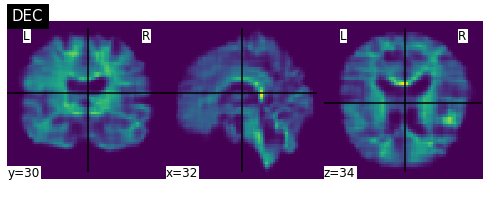

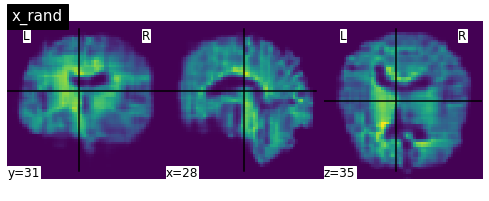

lossStr [3400/200000]
        D: -44.7   
        En_Ge: 2.2e+02 
        Code: 18.0    


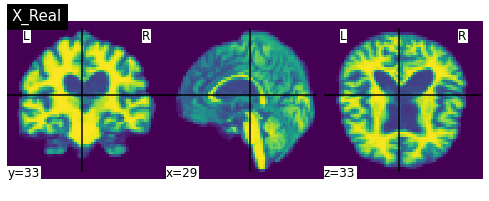

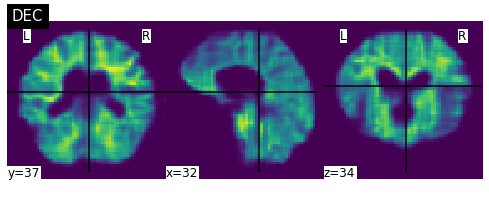

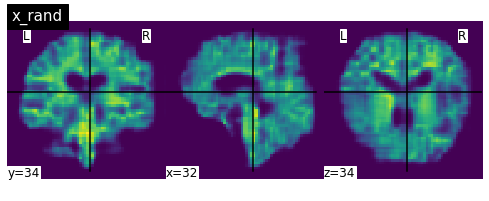

lossStr [3500/200000]
        D: -29.8   
        En_Ge: 1.54e+02
        Code: -6.61   


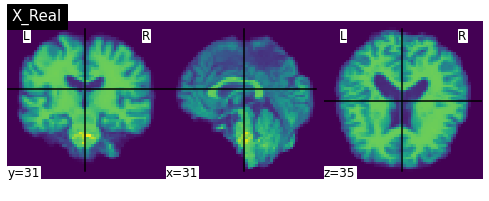

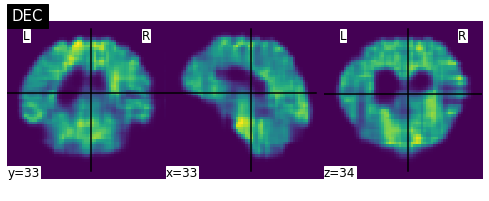

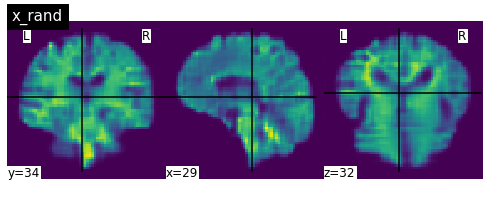


Count: 3500 Mean: 1350.3521925403227
index: 3500, sample_mean: 0.009309118613600731 sample_var: 0.1862906664609909, yellow_mean: -0.0004985245177522302 yellow_var: 0.9995100498199463


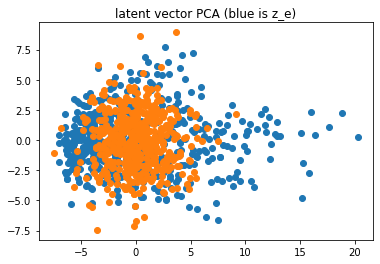

index: 3500, sample_mean: -0.87436842918396 sample_var: 0.046402379870414734, yellow_mean: -0.8589047193527222 yellow_var: 0.05641674995422363


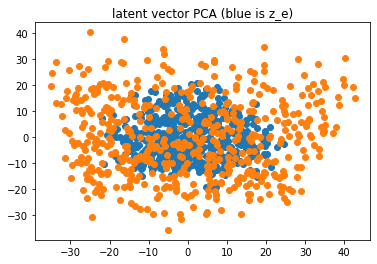

lossStr [3600/200000]
        D: -44.9   
        En_Ge: 2.03e+02
        Code: 81.9    


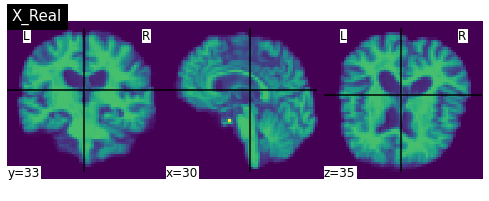

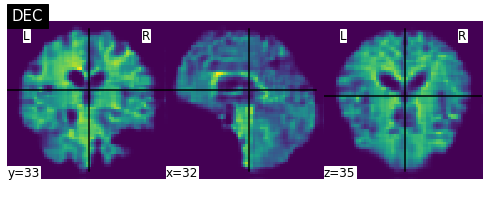

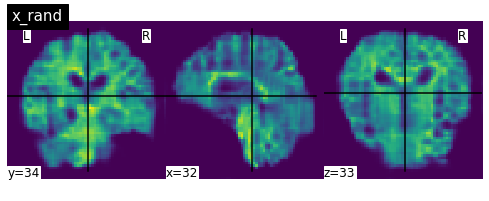

lossStr [3700/200000]
        D: -30.9   
        En_Ge: 1.7e+02 
        Code: 1.57e+02


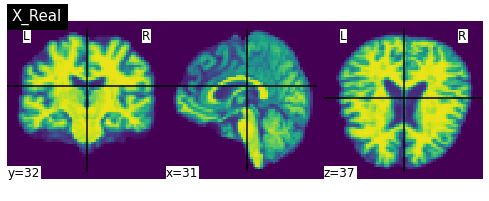

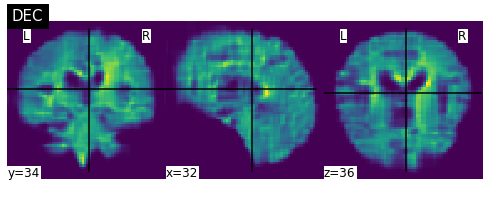

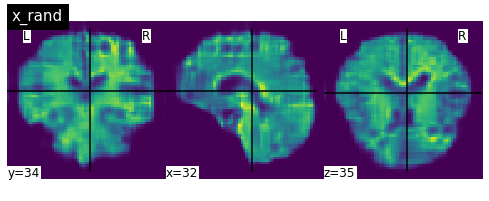

lossStr [3800/200000]
        D: -29.3   
        En_Ge: 1.32e+02
        Code: 23.1    


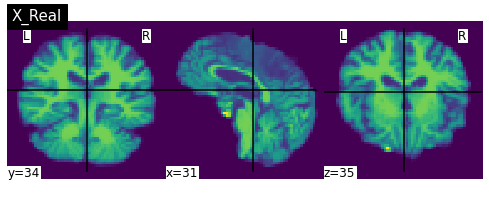

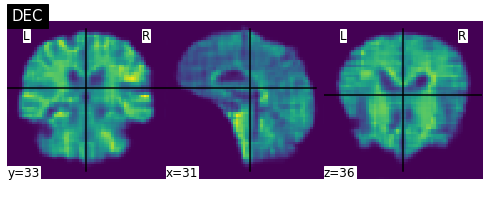

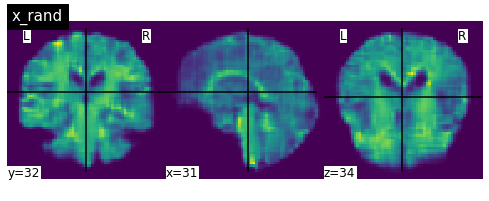

lossStr [3900/200000]
        D: -14.5   
        En_Ge: 2.15e+02
        Code: 9.0     


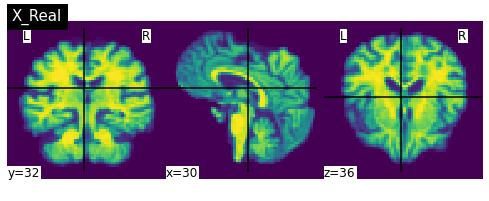

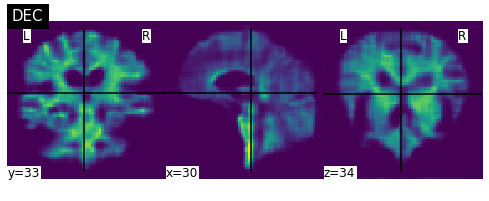

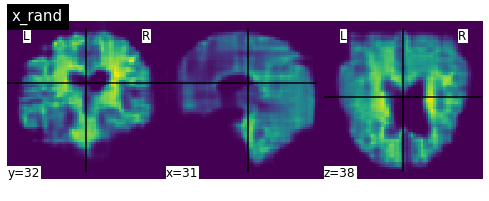

lossStr [4000/200000]
        D: -17.4   
        En_Ge: 1.08e+02
        Code: 15.5    


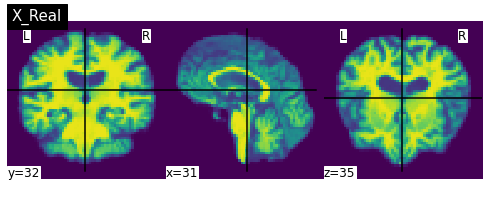

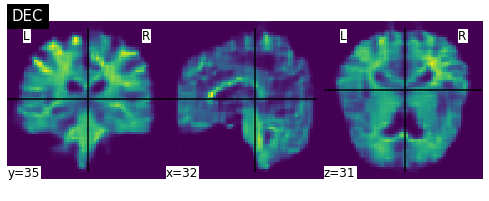

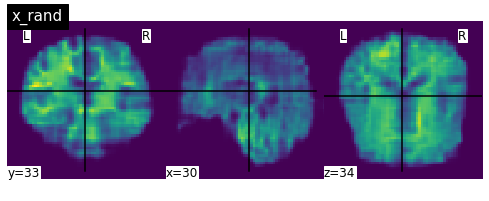


Count: 4000 Mean: 1635.6146673387098
index: 4000, sample_mean: 0.004407197702676058 sample_var: 0.25495558977127075, yellow_mean: 0.0009012763621285558 yellow_var: 0.9985265731811523


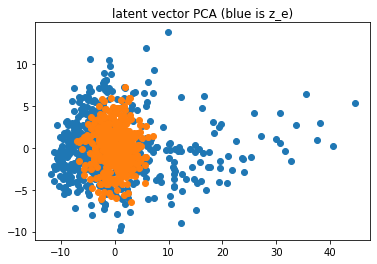

index: 4000, sample_mean: -0.8427558541297913 sample_var: 0.06617777794599533, yellow_mean: -0.8588225841522217 yellow_var: 0.05633678659796715


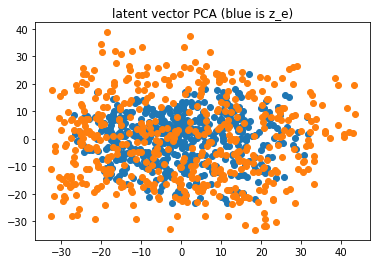

lossStr [4100/200000]
        D: -17.3   
        En_Ge: 1.26e+02
        Code: 8.38    


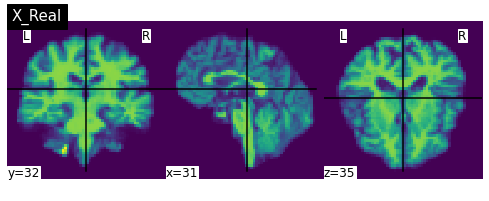

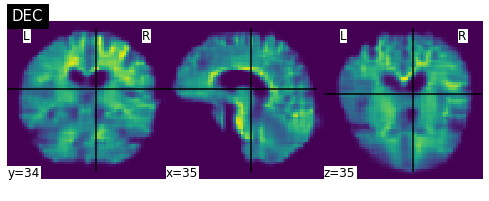

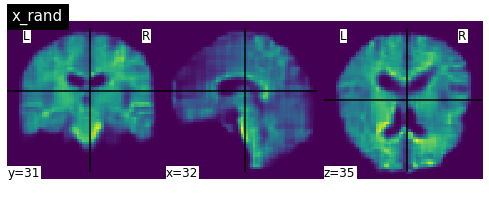

lossStr [4200/200000]
        D: -25.8   
        En_Ge: 1.41e+02
        Code: 19.3    


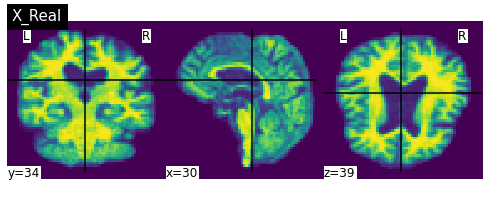

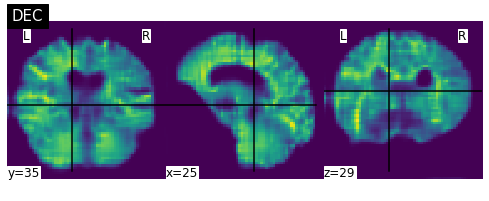

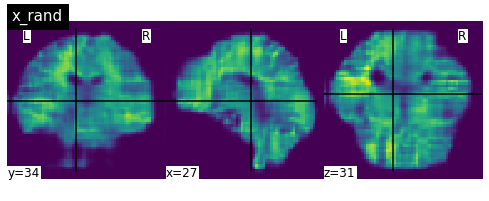

lossStr [4300/200000]
        D: -29.1   
        En_Ge: 2.75e+02
        Code: 94.6    


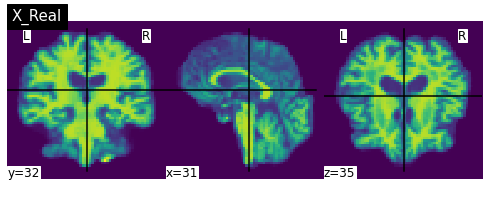

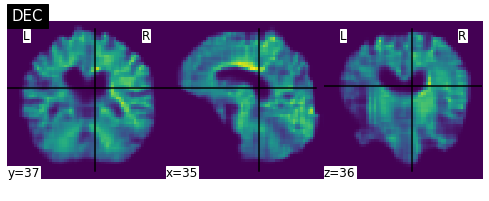

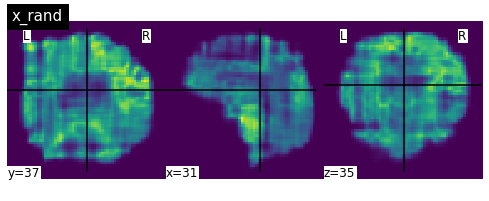

lossStr [4400/200000]
        D: -27.2   
        En_Ge: 2.21e+02
        Code: 13.7    


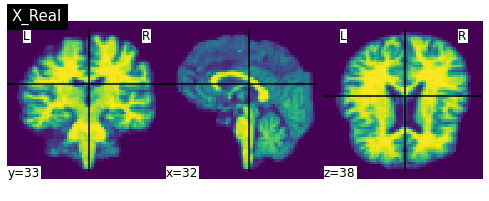

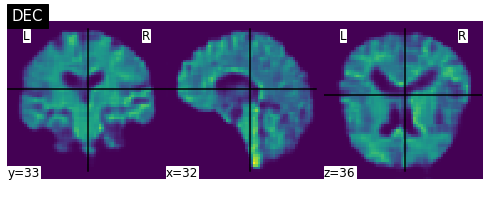

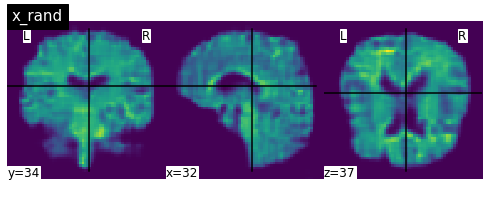

In [ ]:
g_iter = 1
d_iter = 3
cd_iter =1
TOTAL_ITER = 200000
gen_load = inf_train_gen(train_loader)


while iteration <= TOTAL_ITER:
    for p in D.parameters():  
        p.requires_grad = False
    for p in CD.parameters():  
        p.requires_grad = False
    for p in E.parameters():  
        p.requires_grad = True
    for p in G.parameters():  
        p.requires_grad = True

    ###############################################
    # Train Encoder - Generator 
    ###############################################
    for iters in range(g_iter):
        G.zero_grad()
        E.zero_grad()
        real_images = gen_load.__next__().cuda(gpu_1)
        _batch_size = real_images.size(0)
        #remove Volatile Variable Usage
        real_images = real_images.cuda(gpu_1)
        
        z_rand = torch.randn((_batch_size,latent_dim)).cuda(gpu_0)
        z_hat = E(real_images).view(_batch_size,-1).cuda(gpu_0)
        x_hat = G(z_hat)
        x_rand = G(z_rand)
        
        ### MMD between z_e and z_r ###################
        mmd_loss = 0.01 * latent_mmd(E, gen_load, batch_size=BATCH_SIZE, gpu_ind=gpu_1)
        ###############################################
        
        c_loss = -1 * CD(z_hat.cuda(gpu_1)).mean() 
        d_real_loss = D(x_hat.cuda(gpu_0)).mean()
        d_fake_loss = D(x_rand.cuda(gpu_0)).mean()
        d_loss = -d_fake_loss-d_real_loss
        l1_loss = 10 * criterion_l1(x_hat.cuda(gpu_1),real_images) #original weight for L1 loss: 10
        loss1 = l1_loss + d_loss.cuda(gpu_1) + mmd_loss # original weight for c_loss: 1
        
        if iters<g_iter-1:
            loss1.backward()
        else:
            loss1.backward(retain_graph=True)
        e_optimizer.step() 
        g_optimizer.step()
        g_optimizer.step()
    ###############################################
    # Train D
    ###############################################
    for p in D.parameters():  
        p.requires_grad = True
    for p in CD.parameters():  
        p.requires_grad = False
    for p in E.parameters():  
        p.requires_grad = False
    for p in G.parameters():  
        p.requires_grad = False

    for iters in range(d_iter):
        d_optimizer.zero_grad()
        real_images = gen_load.__next__()
        _batch_size = real_images.size(0)
        #remove Volatile Variable
        z_rand = torch.randn((_batch_size,latent_dim)).cuda(gpu_0)
        real_images = real_images.cuda(gpu_1)
        z_hat = E(real_images).view(_batch_size,-1).cuda(gpu_0)
        x_hat = G(z_hat)
        x_rand = G(z_rand)
        real_images = real_images.cuda(gpu_0)
        x_loss2 = -2*D(real_images).mean()+D(x_hat).mean()+D(x_rand).mean()
        
        gradient_penalty_r = calc_gradient_penalty(D,real_images, x_rand, cuda_ind=gpu_1)
        gradient_penalty_h = calc_gradient_penalty(D,real_images, x_hat, cuda_ind=gpu_1)

        loss2 = x_loss2+gradient_penalty_r+gradient_penalty_h
        loss2.backward(retain_graph=True)
        d_optimizer.step()

    ###############################################
    # Train CD
    ###############################################
    for p in D.parameters():  
        p.requires_grad = False
    for p in CD.parameters():  
        p.requires_grad = True
    for p in E.parameters():  
        p.requires_grad = False
    for p in G.parameters():  
        p.requires_grad = False
        
    for iters in range(cd_iter):
        cd_optimizer.zero_grad()
        #remove volatile Variable usage
        z_rand = torch.randn((_batch_size,latent_dim)).cuda(gpu_1)
        z_rand.requires_grad = False
        
        gradient_penalty_cd = calc_gradient_penalty(CD,z_hat.cuda(gpu_1), z_rand, cuda_ind=gpu_1)
        cd_zrand_loss = -CD(z_rand).mean()
        loss3 = cd_zrand_loss - c_loss + gradient_penalty_cd
        loss3.backward()
        cd_optimizer.step()

    ###############################################
    # Visualization
    ###############################################

    if iteration % 100 == 0:
        lossStr = '[{}/{}]'.format(iteration,TOTAL_ITER) + '\n\
        D: {:<8.3}'.format(loss2.item()) + '\n\
        En_Ge: {:<8.3}'.format(loss1.item()) + '\n\
        Code: {:<8.3}'.format(loss3.item()) 
        
        print('lossStr', lossStr)
        feat = np.squeeze((0.5*real_images[0]+0.5).cpu().numpy())
        feat = nib.Nifti1Image(feat,affine = np.eye(4))
        
        plotting.plot_img(feat,title="X_Real")
        plotting.show()

        feat = np.squeeze((0.5*x_hat[0]+0.5).cpu().numpy())
        feat = nib.Nifti1Image(feat,affine = np.eye(4))
        plotting.plot_img(feat,title="DEC")
        
        feat = np.squeeze((0.5*x_rand[0]+0.5).data.cpu().numpy())
        feat = nib.Nifti1Image(feat,affine = np.eye(4))
        plotting.plot_img(feat,title="x_rand")
        plotting.show()
        
    ###############################################
    # Save the losses
    ###############################################
    loss_dict = {
        'index': [iteration],
        'l1_loss': [l1_loss.item()],
        'd_recon': [d_real_loss.item()],
        'd_fake': [d_fake_loss.item()],
        'd_real': [-2*D(real_images).mean().item()],
        'mmd_loss': [mmd_loss.item()],
        'd_loss': [d_loss.item()],
        'cd_loss': [c_loss.item()],
        'cd_zrand_loss': [cd_zrand_loss.item()],
        'gp_r': [gradient_penalty_r.item()],
        'gp_h': [gradient_penalty_h.item()],
        'gp_cd': [gradient_penalty_cd.item()],
        'loss1': [loss1.item()],
        'loss2': [loss2.item()],
        'loss3': [loss3.item()],
    }
    df = add_loss(df, loss_dict)
        

    ###############################################
    # Model Save
    ###############################################
    if iteration % 500 == 0 and iteration != 0:
        torch.save(G.state_dict(),f'./mmd_checkpoint/G_iter'+str(iteration)+'.pth')
        torch.save(D.state_dict(),f'./mmd_checkpoint/D_iter'+str(iteration)+'.pth')
        torch.save(E.state_dict(),f'./mmd_checkpoint/E_iter'+str(iteration)+'.pth')
        torch.save(CD.state_dict(),f'./mmd_checkpoint/CD_iter'+str(iteration)+'.pth')
        calc_mmd(train_loader, G, df, iteration, gpu_ind=gpu_1, path='test_data_mmd')
        viz_pca(E, dataset, latent_size=latent_dim, index=iteration, is_cd=True, gpu_ind=gpu_1)
        viz_pca(G, dataset, latent_size=latent_dim, index=iteration, gpu_ind=gpu_1)
        
        write_loss(df)
        
    iteration += 1
   
    

In [ ]:
test = torch.tensor([[1, 2, 3], [15, 14, 13], [100, 80, 60]]).float()
test = torch.tensor([1, 2, 3, 4, 5, 6, 100]).float()
test = test.view(test.shape[0], -1)
print(test)
F.softmax(test, dim=0)

In [ ]:
torch.cuda.empty_cache()

In [ ]:
%debug